In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
os.chdir('K:/ecole/github/televerser/civ6/misc')

&nbsp;
### Functions
&nbsp;

In [2]:
#input should be np array of image
#use np array index to approximate actual coordinates
def read_xy_from_pixels(target,xmax,xmin,ymax,ymin,
                        vert_flip=False):
    
    output=[]
    
    matrix=target.copy()
    
    #vertically flip the image
    if vert_flip:        
        matrix=np.flip(target,axis=0)
    
    #convert resolution to the scale of axis
    yfactor=(ymax-ymin)/matrix.shape[0]
    xfactor=(xmax-xmin)/matrix.shape[1]
    
    #capture the curve
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j]!=0:
                output.append((xmin+j*xfactor,ymin+i*yfactor))
    
    return sorted(output)

In [3]:
#convert hex to rgb
def hex_to_rgb(hex):
  
    rgb=[]
    for i in (0,2,4):
        decimal = int(hex[i:i+2],16)
        rgb.append(decimal)
        
    return tuple(rgb)

In [4]:
#assign color to fixed centroid
#based upon euclidean distance
def cluster_predict(img,color2terrain):
    
    #get dimension
    maph=img.shape[0]
    mapw=img.shape[1]    
    
    #get hex color
    centroid_colors=[hex_to_rgb(i[1:]) for i in color2terrain.keys()]
    
    #repeat centroid colors
    repeated_arr=[np.repeat(np.array(i).reshape(1,-1),mapw*maph,axis=0) for i in centroid_colors]
    
    #compute sum of squared error
    sse_arr=[np.square(img.reshape(mapw*maph,3)[:,[2,1,0]]-i).sum(axis=1) for i in repeated_arr]
    
    #take the smallest sse as assigned color
    assignment=np.argmin(np.c_[sse_arr],axis=0)
    
    return assignment

In [5]:
#convert rgb to hex
def rgb_to_hex(rgb):
    return '#'+'%02x%02x%02x' % rgb

&nbsp;
### Americas
&nbsp;

In [6]:
#color mapping
mapping={'#fffffe': 0,
 '#fbfda2': 1,
 '#f6f249': 2,
 '#c08b44': 3,
 '#912614': 4,
 '#4a110e': 5,
'#000000':6}

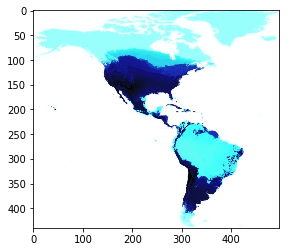

In [7]:
#bee species richness index
# https://www.researchgate.net/figure/High-Resolution-Bee-Species-Richness-Projections_fig3_346031478
img=cv2.imread('honeybees america.jpg',1)
plt.imshow(img)

In [8]:
# # k means to get centroid colors
# # useful when you prefer other types of viz to show topographic map

# from sklearn.cluster import KMeans
# num_of_clusters=6
# X=img.reshape(img.shape[0]*img.shape[1],3)[:,[2,1,0]]
# clf=KMeans(n_clusters=num_of_clusters)
# clf.fit(X)
# centroids=[i for i in range(clf.cluster_centers_.shape[0])]
# for i in range(clf.cluster_centers_.shape[0]):
#     centroids[i]=rgb_to_hex(tuple([int(np.ceil(j)) for j in clf.cluster_centers_[i].tolist()]))
# print(centroids)
# plt.scatter(range(num_of_clusters),range(num_of_clusters),c=centroids,s=500)
# plt.show()

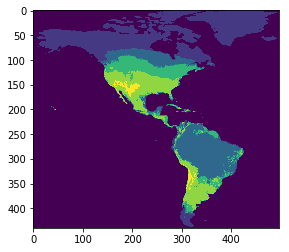

In [9]:
#get assigned cluster
arr=cluster_predict(img,mapping)
arr=arr.reshape(img.shape[0],img.shape[1])
plt.imshow(arr)

#only care about the darkest color in the map
arr[arr<5]=0

#extract coordinates
data=read_xy_from_pixels(arr,-10,-170,85,-56,
                        vert_flip=True)

In [10]:
#get rgbs of our targets
target_rgbs=img[arr!=0]

#map black color into the same dimension as targets
benchmark_rgbs=np.repeat([[0,0,0]],target_rgbs.shape[0],axis=0)

#create dataframe
df=pd.DataFrame()
df['lat']=[i[1] for i in data]
df['lon']=[i[0] for i in data]

#compute log scale euclidean distance from actual color to assigned color
df['val']=np.log(np.square(target_rgbs-benchmark_rgbs).sum(axis=1))

#remove negative number
df[df['val']<=1.5]=1.5

#prepare output
export=pd.DataFrame(columns=df.columns)
export=export.append(df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


&nbsp;
### Eurasia
&nbsp;

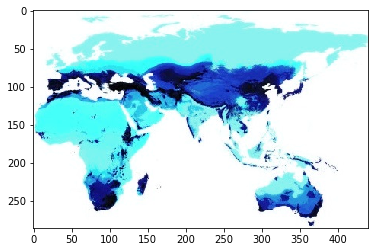

In [11]:
#bee species richness index
# https://www.researchgate.net/figure/High-Resolution-Bee-Species-Richness-Projections_fig3_346031478
img=cv2.imread('honeybees eurasia.jpg',1)
plt.imshow(img)

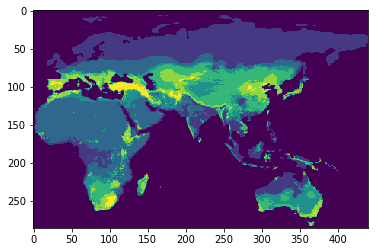

In [12]:
#get assigned cluster
arr=cluster_predict(img,mapping)
arr=arr.reshape(img.shape[0],img.shape[1])
plt.imshow(arr)

#only care about the darkest color in the map
arr[arr<5]=0

#extract coordinates
data=read_xy_from_pixels(arr,180,-20,85,-45,
                        vert_flip=True)

In [13]:
#get rgbs of our targets
target_rgbs=img[arr!=0]

#map black color into the same dimension as targets
benchmark_rgbs=np.repeat([[0,0,0]],target_rgbs.shape[0],axis=0)

#create dataframe
df=pd.DataFrame()
df['lat']=[i[1] for i in data]
df['lon']=[i[0] for i in data]

#compute log scale euclidean distance from actual color to assigned color
df['val']=np.log(np.square(target_rgbs-benchmark_rgbs).sum(axis=1))

#remove negative number
df[df['val']<=1.5]=1.5

export=export.append(df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [14]:
#shrink data size
subset=export[export['val']-export['val'].std()>=export['val'].mean()]
subset['la']=subset['lat'].apply(lambda x:round(x,0))
subset['lo']=subset['lon'].apply(lambda x:round(x,0))
subset=subset.sort_values(['la','lo','val'],ascending=False)
subset=subset.loc[subset[['la','lo']].drop_duplicates().index]
del subset['la']
del subset['lo']
subset.to_csv('export.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


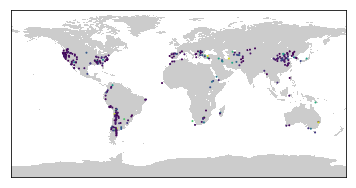

In [15]:
#viz
m=Basemap()
x,y=m(subset['lon'],subset['lat'])
m.drawlsmask()
plt.scatter(x,y,c=subset['val'],s=1)